<a href="https://colab.research.google.com/github/VMBoehm/N3AS_Project_Malika/blob/main/FIRSTSAILENCYMAPTHING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#! ls ./drive/MyDrive/

In [4]:
import matplotlib.pyplot as plt

In [5]:
train_gen = keras.preprocessing.image_dataset_from_directory(
    './drive/MyDrive/z1',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1534,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False
)

valid_gen = keras.preprocessing.image_dataset_from_directory(
    './drive/MyDrive/z1',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1534,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False
)

Found 730 files belonging to 2 classes.
Using 584 files for training.
Found 730 files belonging to 2 classes.
Using 146 files for validation.


In [21]:
class_names = train_gen.class_names
print(class_names)

['class_massive_0', 'class_massive_10']


In [31]:
pic = train_gen.take(1)

In [32]:
print(pic)

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [43]:
import matplotlib.pyplot as plt



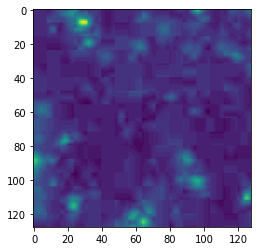

In [6]:
plt.imshow(np.squeeze(next(iter(valid_gen))[0][0]/255))

In [7]:
new_model = tf.keras.models.load_model('./drive/MyDrive/my_model')


In [8]:
# TASK: add validation data (https://keras.io/api/models/model_training_apis/)
new_model.fit(train_gen, epochs=3, validation_data=valid_gen)

Epoch 1/3
19/19 [==============================] - 19s 195ms/step - loss: 1.2442 - binary_accuracy: 0.6695 - val_loss: 2.8579e-04 - val_binary_accuracy: 1.0000
Epoch 2/3
19/19 [==============================] - 1s 57ms/step - loss: 1.3918e-04 - binary_accuracy: 1.0000 - val_loss: 2.6357e-05 - val_binary_accuracy: 1.0000
Epoch 3/3
19/19 [==============================] - 2s 76ms/step - loss: 3.3697e-05 - binary_accuracy: 1.0000 - val_loss: 1.7828e-05 - val_binary_accuracy: 1.0000


In [9]:
new_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 gray_to_rgb_norm (Gray2VGGI  (None, 128, 128, 3)      0         
 nput)                                                           
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 2049  

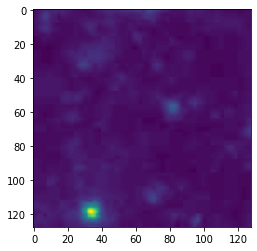

In [53]:
from keras.preprocessing.image import load_img, img_to_array
_img = load_img("./drive/MyDrive/z1/class_massive_10/63.jpg",target_size=(128,128),color_mode= "grayscale")
plt.imshow(_img)
plt.show()

In [59]:
input_arr = tf.keras.preprocessing.image.img_to_array(_img)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)

In [60]:
print(predictions)

[[14.989194]]


In [65]:
images = tf.Variable(input_arr, dtype=float)

with tf.GradientTape() as tape:
    pred = new_model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

In [66]:
dgrad_abs = tf.math.abs(grads)

In [68]:
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

In [69]:
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

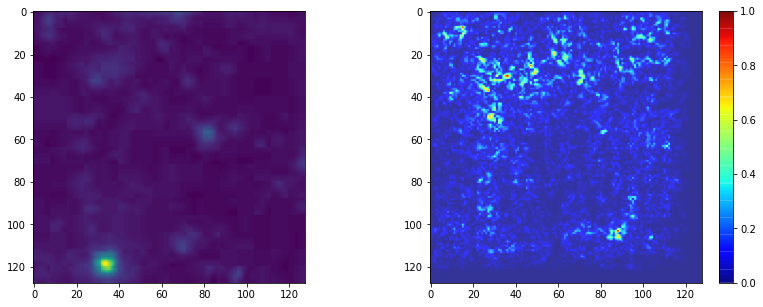

In [70]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(_img)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

In [11]:
from keras.applications.inception_v3 import preprocess_input

In [54]:
v =tf.keras.utils.img_to_array(_img)

In [55]:
print(tf.shape(v))

tf.Tensor([128 128   1], shape=(3,), dtype=int32)


In [48]:
def prep_input(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [128,128])
    return image

In [49]:
def norm_flat_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm




In [50]:
def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")

In [17]:
img_path= "./drive/MyDrive/z1/class_massive_10/63.jpg"

In [64]:

input_img = prep_input(input_arr)

ValueError: ignored

In [52]:

input_img = tf.keras.applications.densenet.preprocess_input(input_img)


InvalidArgumentError: ignored